# Morphemic language with flexible order

### Set-up

In [1]:
import random
import numpy as np
from copy import deepcopy
from importlib import reload 

import syntactic_wm as cjn ## Our model
reload(cjn)

################
## Parameters ##
################
num_steps = 50 # number of time steps taken by each word input.
head = 1 # number of time steps buffering the front of each sentence.
tail = 20 # number of time steps buffering the end of each sentence.
no_periods = 1 # number of epochs each sentence is presented to the model.

lambda_cc = 20 # learning rate of short-term synaptic plasticity amongst role neurons.
lambda_cf = 1 # learning rate of short-term synaptic plasticity between role and word neurons.

tau = 0.5 # modifies change in firing rate at each time step to simulate continuous time.

beta = 1 # decay factor of firing rates.

n_word_neurons = 15 # number of word neurons initialised (f)
n_role_neurons = 10 # number of role neurons initialised (c)

gamma = 0.5 # factor dampening connectivity amongst role neurons.

epsilon_cc = 8 # the ceiling of c-c connections when without long-term encoding, while taking into account of negative bias k. 
k_cc = 5 # negative bias, i.e. negative k_cc is the floor of c-c connections.

epsilon_cf = 3 # the ceiling of c-f connections when without long-term encoding, while taking into account of negative bias k. 
k_cf = 1 # negative bias, i.e. negative k_cf is the floor of c-f connections.

h = 2 # normalising factor for inhibition between c-f connections.

W_mc = 5.6 # connectivity between morph and role neurons (non-encodable)
W_mm = -10 # conneectivity between morpheme neurons to itself (non-encodable)

W_ff = -0.5  # connectivity amongst word neurons (non-encodable)

unified_noise = 0 # noise level if noise is present
cc_noise = False # any noise amongst role neurons
wc_noise = False # any noise between role and word neurons

k_L_cc = 5.7 # long-term encoding amongst role neurons 
k_L_cf = 1.7 # long-term encoding between role and word neurons

seed_ = 0 # setting default random seed
np.random.seed(seed_)
random.seed(seed_)

## Morphemes

In the follow simulation, we replace long-term encodings with morphemes that will determine the role of the words.

In [2]:
LT_wc_knowledge = [] # empty long-term encoding between role and word neurons
morph_nodes = [0,1,2,3,4,5,6] # defining available morpheme neurons
LT_cc_knowledge = [] # empty long-term encoding amongst role neurons

# building the sentence
# each word is accompanied by a morpheme neuron
# although this is in simple chronological order, you can reorder the words and morphemes arbitrarily.
sentence = []
for n in range(head): sentence.append(cjn.in_in())
for n in range(num_steps): sentence.append(cjn.in_in(word=0, morpheme=0))
for n in range(num_steps): sentence.append(cjn.in_in(word=1, morpheme=1))
for n in range(num_steps): sentence.append(cjn.in_in(word=2, morpheme=2))
for n in range(num_steps): sentence.append(cjn.in_in(word=3, morpheme=3))
for n in range(num_steps): sentence.append(cjn.in_in(word=4, morpheme=4))
for n in range(num_steps): sentence.append(cjn.in_in(word=5, morpheme=5))
for n in range(num_steps): sentence.append(cjn.in_in(word=6, morpheme=6))
for n in range(tail): sentence.append(cjn.in_in())

## initialising the working memory model
WM_ori = cjn.feature_layer(n_role_neurons = n_role_neurons,
                       cc_connectivity_factor = gamma,
                       activation_decay = beta,
                       LR_c = lambda_cc,
                       LR_w = lambda_cf,
                       cc_max_connection = epsilon_cc - k_cc,
                       cf_max_connection = epsilon_cf - k_cf,
                       n_word_neurons = n_word_neurons,
                       time_factor = tau,
                       LT_wc_knowledge = LT_wc_knowledge,
                       cc_learnt_weight = k_L_cc - k_cc,
                       cf_learnt_weight = k_L_cf - k_cf,
                       input_node_connectivity = W_ff,
                       LT_cc_knowledge = LT_cc_knowledge,
                       cc_floor_weight = -k_cc, 
                       cf_floor_weight = -k_cf,
                       unified_noise = unified_noise,
                       cc_noise = cc_noise,
                       wc_noise = wc_noise,
                       cf_conj_factor = h,
                       mc_connectivity_factor = W_mc,
                       mm_connectivity_factor = W_mm,
                       morph_nodes = morph_nodes
                      )


# running the encoding phase
role_neuron_dict, cc_connection_dict, word_neuron_dict, cf_connection_dict, WM_ori, cc_conn_hx, c_act_hx, cf_conn_hx, f_act_hx, cc_long_weights_hx, wc_long_weights_hx, morph_act_hx, wm_conn_hx = cjn.run_model(model=WM_ori, time_steps=len(sentence)*no_periods, sentence=sentence)



********************
Epoch = 1
Number of recorded time steps:  371
********************


### Visualisation of encoding

We can visualise the learning that occurred during the encoding phase.

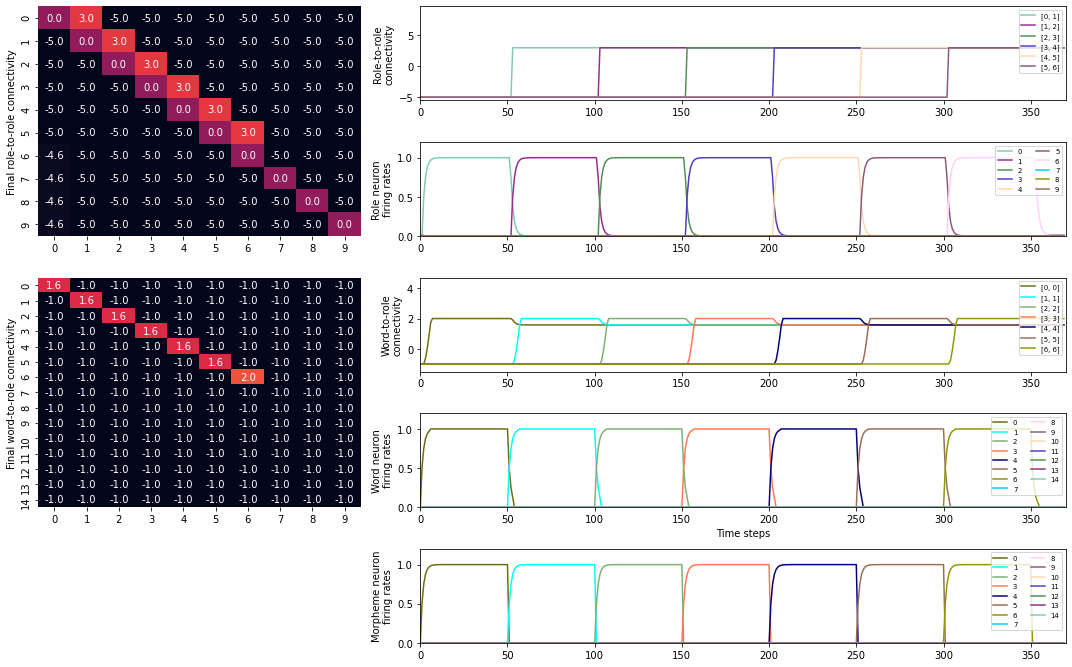

In [3]:
# because there were no pre-defined long-term encoding, we need to specify the connections that are of interest to us to be plotted.
cc_to_track = [[0,1,2,3,4,5,6]] 
cf_to_track = [[0,0],[1,1],[2,2],[3,3],[4,4],[5,5],[6,6]]

cjn.plot_results(sentence, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, cc_to_track, cf_to_track, cc_conn_hx, cf_conn_hx, c_act_hx, f_act_hx, morph_act_hx)


### Recall of the encoded sentence with morphemes

We test that the network is able to recall the above encoded sentence with the accompanying morphemes.

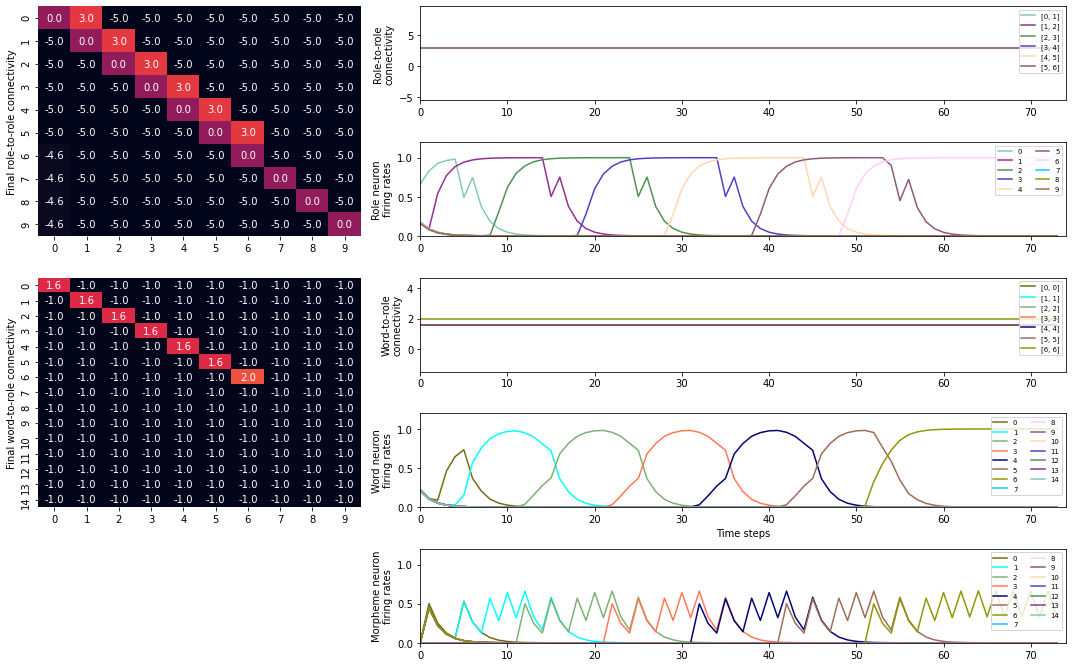

The final recall output is: 
[[0.0], [1.0], [2.0], [3.0], [4.0], [5.0], [6.0]]


In [4]:
WM_r = deepcopy(WM_ori) # copy the encoded model
initial_steps = 5 # initial 5 steps during recall will have input into the first role neuron
n_steps = 75 # total number of time steps taken during recall

# building recall input with 5 initial time steps with input into the first role neuron and then no further input.
recall_input = []
for n in range(initial_steps): recall_input.append(cjn.in_in(role=0))
for n in range(n_steps-initial_steps): recall_input.append(cjn.in_in())

# running the recall phase
cc_conn_hx_r, c_act_hx_r, cf_conn_hx_r, f_act_hx_r, cc_long_weights_hx_r, wc_long_weights_hx_r, morph_act_hx_r, wm_conn_hx_r = cjn.recall_feat_layer(WM_r,recall_input,n_steps=n_steps,initial_steps=initial_steps)

# visualise the recall
cjn.plot_results(recall_input, epsilon_cc-k_cc+k_L_cc, -k_cc, epsilon_cf-k_cf+k_L_cf, -k_cf, cc_to_track, cf_to_track, cc_conn_hx_r, cf_conn_hx_r, c_act_hx_r, f_act_hx_r, morph_act_hx_r)

# Final recall determined by argmax at each time step
print('The final recall output is: ')
print(cjn.argmax_sentence(f_act_hx_r))